## Image Captioning 
- Genrating Captions for Images

## Steps
- Data collection
- Understanding the data
- Data Cleaning
- Loading the training set
- Data Preprocessing — Images
- Data Preprocessing — Captions
- Data Preparation using Generator Function
- Word Embeddings
- Model Architecture
- Inference
- Evaluation

## Read Caption/ Data Collection
There are many open source datasets available for this problem, like Flickr 8k
(containing8k images), Flickr 30k (containing 30k images), MS COCO (containing
180k images), etc.

I've used flickr8k dataset that is available on kaggle. You can
run download_data.sh shell script. Before that put kaggle.json which is kaggle api
key in same directory.
This dataset contains 8000 images each with 5 captions (as we have already seen in
the Introduction section that an image can have multiple captions, all being relevant
simultaneously).

These images are bifurcated as follows:
- Training Set — 6000 images
- Dev Set — 1000 images
- Test Set — 1000 images

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import keras
import re
import nltk
from nltk.corpus import stopwords
import string
import json
from time import time
import pickle
from keras.applications.vgg16 import VGG16
from keras.applications.resnet50 import ResNet50, preprocess_input, decode_predictions
from keras.preprocessing import image
from keras.models import Model, load_model
from keras.preprocessing.sequence import pad_sequences
from keras.utils import to_categorical
from keras.layers import Input, Dense, Dropout, Embedding, LSTM
from keras.layers.merge import add

In [2]:
def readText(path):
    with open(path) as f:
        captions = f.read()
    return captions

In [9]:
captions = readText("D:\\Desktop\\Flickr_Data\\Flickr_TextData\\Flickr8k.token.txt")

In [4]:
print(type(captions))

<class 'str'>


In [5]:
## Length of the Caption text Data
captions = captions.split("\n")
print(len(captions))

40461


## Print Caption

In [6]:
captions[0]

'1000268201_693b08cb0e.jpg#0\tA child in a pink dress is climbing up a set of stairs in an entry way .'

In [7]:
captions[-1]

''

<b>So Last Caption is empty. To Clean and achive accurate data, We can discard id by performing sclicing operation. </b>

In [10]:
captions = captions.split("\n")[:-1]

In [11]:
## Now, Length of the Caption text Data
print(len(captions))

40460


In [12]:
captions[-1]

'997722733_0cb5439472.jpg#4\tA rock climber practices on a rock climbing wall .'

## Understanding the data
If you have downloaded the data from the Kaggle that I have provided, then, along with images, you will also get some text files related to the images. One of the files
is “Flickr8k.token.txt” which contains the name of each image along with its 5
captions. 

To read the 5 caption for a Sigle Image We have to create the Dictinary to map each Image with List of Caption It has...

In [13]:
# creating a "descriptions" dictionary  where key is 'img_name' and value is list of captions corresponding to that image_file.

descriptions = {}

for ele in captions:
    i_to_c = ele.split("\t")
    img_name = i_to_c[0].split(".")[0]
    cap = i_to_c[1]
    
    if descriptions.get(img_name) == None:
        descriptions[img_name] = []

    descriptions[img_name].append(cap)

In [14]:
## We can read this file as follows : 
descriptions['1000268201_693b08cb0e']

['A child in a pink dress is climbing up a set of stairs in an entry way .',
 'A girl going into a wooden building .',
 'A little girl climbing into a wooden playhouse .',
 'A little girl climbing the stairs to her playhouse .',
 'A little girl in a pink dress going into a wooden cabin .']

## Fatch Images 

In [15]:
import cv2
import matplotlib.pyplot as plt 

In [16]:
img = cv2.imread("D:\\Desktop\\Flickr_Data\\Images\\1000268201_693b08cb0e.jpg")

<function matplotlib.pyplot.show(close=None, block=None)>

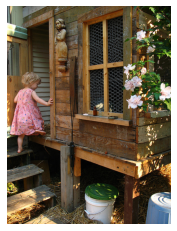

In [17]:
img = cv2.cvtColor(img,cv2.COLOR_BGR2RGB)
plt.imshow(img)
plt.axis("off")
plt.show

So, We can Conclude that Our modle will give 5 caption is seem to be correct which is in Image.

## Data Cleaning
To clean the sentences We usualy perform some NLTK library function like - Stopeword removel, Stemming etc. same as we perform in Sentiment analysis. But here we can not perform these operation here. because we have to manage grammer meaning of the sentences for Eg. if we perform stemming on example "Running" it will make Run which will come out different meaning for the caption.

Here When we deal with text, we generally perform some basic cleaning like lowercasing all the words (otherwise “hello” and “Hello” will be regarded as two separate
words), removing special tokens (like ‘%’, ‘$’, ‘#’, etc.), eliminating words which
contain numbers (like ‘hey199’, etc.).


In [18]:
""" 1. lower each word
    2. remove puntuations
    3. remove words less than length 1 """ 

def clean_text(sample):
    sample = sample.lower()
    
    sample = re.sub("[^a-z]+"," ",sample)
    
    sample = sample.split()
    
    sample = [s for s in sample if len(s)>1]
    
    sample = " ".join(sample)
    
    return sample

In [21]:
## Check Function for sample Eg.
clean_text("A cat is sitting over the house #64")

'cat is sitting over the house'

In [22]:
## Clean All the Caption

In [23]:
#  modify all the captions i.e - cleaned captions

for key, desc_list in descriptions.items():
    for i in range(len(desc_list)):
        desc_list[i] = clean_text(desc_list[i])

In [24]:
descriptions['1000268201_693b08cb0e'] # Check for an image 

['child in pink dress is climbing up set of stairs in an entry way',
 'girl going into wooden building',
 'little girl climbing into wooden playhouse',
 'little girl climbing the stairs to her playhouse',
 'little girl in pink dress going into wooden cabin']

## Data Preprocess File

In [25]:
# Write the data to text file

with open("descriptions.txt","w") as f:
    f.write(str(descriptions))

In [26]:
#  reading description file

f = open("descriptions.txt", 'r')
descriptions = f.read()
f.close()

json_acceptable_string = descriptions.replace("'", "\"")
descriptions = json.loads(json_acceptable_string)

## Create a vocabulary 
Create a vocabulary of all the unique words present across all the 8000*5 (i.e. 40000) image captions (corpus) in the data set However, if we think about it, many of these words will occur very few times, say 1, 2 or 3 times. Since we are creating a predictive model, we would not like to have all the words present in our vocabulary but the words which are more likely to occur or which are common. This helps the model become more robust to outliers and make less mistakes.

In [27]:
# finding the unique vocabulary 

vocabulary = set()

for key in descriptions.keys():
    [vocabulary.update(i.split()) for i in descriptions[key]]

print('Vocabulary Size: %d' % len(vocabulary))

Vocabulary Size: 8424


In [28]:
#  ALl words in description dictionary
all_vocab =  []

for key in descriptions.keys():
    [all_vocab.append(i) for des in descriptions[key] for i in des.split()]

print('Vocabulary Size: %d' % len(all_vocab))
print(all_vocab[:15])

Vocabulary Size: 373837
['child', 'in', 'pink', 'dress', 'is', 'climbing', 'up', 'set', 'of', 'stairs', 'in', 'an', 'entry', 'way', 'girl']


In [29]:
# Hence we consider only those words which occur at least 10 times in the entire corpus. The code for this is below
# Filter Words from the Vocab according to Certaion treshhold frequency

In [30]:
#  count the frequency of each word, sort them and discard the words having frequency lesser than threshold value

import collections


counter= collections.Counter(all_vocab)

dic_ = dict(counter)

threshelod_value = 10

sorted_dic = sorted(dic_.items(), reverse=True, key = lambda x: x[1])
sorted_dic = [x for x in sorted_dic if x[1]>threshelod_value]
all_vocab = [x[0] for x in sorted_dic]
len(all_vocab)

1845

In [31]:
# Sort this dictonary according to the freq Count

In [33]:
print(len(all_vocab)) # Show Sorted >freq uniqe words

1845


So We have started with somewhere arount 317000 words and to perfor preproceesing opretion we have left 1845 words

So now we have only 1845 unique words in our vocabulary. However, we will append 0’s (zero padding explained later) and thus total words = 1845+1 = 1846 (one index for the 0).



## Prepare Train/Test Data

## Read Files

In [34]:
# TrainImagesFile
f = open("D:\\Desktop\\Flickr_Data\\Flickr_TextData\\Flickr_8k.trainImages.txt")
train = f.read()
f.close()


In [35]:
train  = [e.split(".")[0] for e in train.split("\n")[:-1]]

In [36]:
# TestImagesFile
f = open("D:\\Desktop\\Flickr_Data\\Flickr_TextData\\Flickr_8k.testImages.txt")
test = f.read()
f.close()

In [37]:
test  = [e.split(".")[0] for e in test.split("\n")[:-1]]

In [38]:
train[:5]

['2513260012_03d33305cf',
 '2903617548_d3e38d7f88',
 '3338291921_fe7ae0c8f8',
 '488416045_1c6d903fe0',
 '2644326817_8f45080b87']

In [39]:
# create train_descriptions dictionary, which will be similar to earlier one, but having only train samples
# add startseq + endseq 

train_descriptions = {}

for t in train:
    train_descriptions[t] = []
    for cap in descriptions[t]:
        cap_to_append = "startseq " + cap + " endseq"
        train_descriptions[t].append(cap_to_append)

In [40]:
train_descriptions['1000268201_693b08cb0e']

['startseq child in pink dress is climbing up set of stairs in an entry way endseq',
 'startseq girl going into wooden building endseq',
 'startseq little girl climbing into wooden playhouse endseq',
 'startseq little girl climbing the stairs to her playhouse endseq',
 'startseq little girl in pink dress going into wooden cabin endseq']

## Image  Preprocessing
### Transfer Learning
- Image --> Feature
- Text -->Feture

## Ster - 1 Image Feature Extraction
Images are nothing but input (X) to our model. As you may already know that any input to a model must be given in the form of a vector. We need to convert every image into a fixed sized vector which can then be fed as input to the neural network. For this purpose, we opt for transfer learning by using the ResNet50 model (Convolutional Neural Network).
ResNet50 is not the first model coming from the ResNet family. The original model was called the Residual net or ResNet and was another milestone in the CV domain back in 2015. The main motivation behind this model was to avoid poor accuracy as the model went on to become deeper. Additionally, if you are familiar with Gradient Descent, you would have come across the Vanishing Gradient issue – the ResNet model aimed to tackle this issue as well. ResNet34(ResNet50 also follows a similar technique with just more layers)

In [41]:
IMG_PATH = "D:\\Desktop\\Flickr_Data\\Images"

In [42]:
model = ResNet50(weights="imagenet", input_shape=(224,224,3)) 
model.summary()

Model: "resnet50"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 230, 230, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
conv1_conv (Conv2D)             (None, 112, 112, 64) 9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
conv1_bn (BatchNormalization)   (None, 112, 112, 64) 256         conv1_conv[0][0]                 
___________________________________________________________________________________________

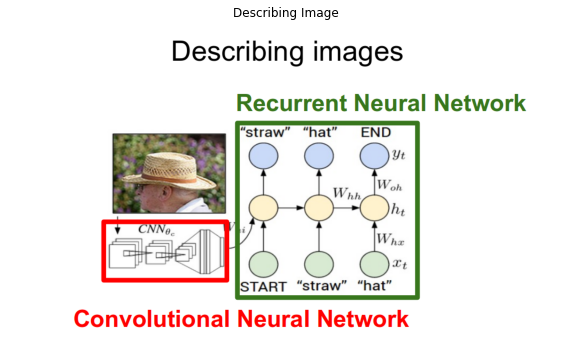

In [94]:
%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
img = mpimg.imread('g26.png')
plt.figure(figsize=(10,10))
plt.title("Describing Image")
plt.axis("off")
imgplot = plt.imshow(img)

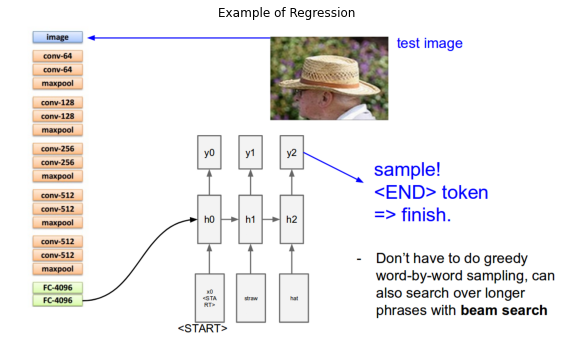

In [96]:
%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
img = mpimg.imread('g28.png')
plt.figure(figsize=(10,10))
plt.title("Example of Regression")
plt.axis("off")
imgplot = plt.imshow(img)

In [43]:
# Create a new model, by removing the last layer (output layer of 1000 classes) from the resnet50
model_new = Model(model.input, model.layers[-2].output)

In [44]:
def preprocess_image(img):
    img = image.load_img(img, target_size=(224,224))
    img = image.img_to_array(img)
    img = np.expand_dims(img, axis=0)
    img = preprocess_input(img)
    return img

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


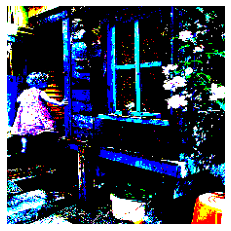

In [45]:
img = preprocess_image("D:\\Desktop\\Flickr_Data\\Images\\1000268201_693b08cb0e.jpg")
plt.imshow(img[0])
plt.axis("off")
plt.show()

## Data Preproccesing for Images/Image Encoding :
It is basically when we feed the image into the madel it gives an enconding as output each corresponding image.
    Preprocessing --> paass through ResNet Model ---> Output(encoding)

In [46]:
def encode_image(img):
    img = preprocess_image(img)
    feature_vector = model_new.predict(img)
    feature_vector = feature_vector.reshape(feature_vector.shape[1],)
    return feature_vector

In [47]:
encode_image("D:\\Desktop\\Flickr_Data\\Images\\1000268201_693b08cb0e.jpg")

array([0.06535921, 0.16782534, 0.3251761 , ..., 0.05107138, 0.32821208,
       1.0043364 ], dtype=float32)

In [48]:
start = time()

from tqdm.notebook import tqdm

encoding_train = {}

for ix, img_id in tqdm(enumerate(train),total=len(train)):
     
    img = IMG_PATH+"/"+img_id+".jpg".format(train[ix])
    # encoding_train[img[len(images):]] = encode_image(img)
    encoding_train[img_id] = encode_image(img)
    if ix%100==0:
        print("Encoding image- "+ str(ix))
    
print("Time taken in seconds =", time()-start)

Encoding image- 0
Encoding image- 100
Encoding image- 200
Encoding image- 300
Encoding image- 400
Encoding image- 500
Encoding image- 600
Encoding image- 700
Encoding image- 800
Encoding image- 900
Encoding image- 1000
Encoding image- 1100
Encoding image- 1200
Encoding image- 1300
Encoding image- 1400
Encoding image- 1500
Encoding image- 1600
Encoding image- 1700
Encoding image- 1800
Encoding image- 1900
Encoding image- 2000
Encoding image- 2100
Encoding image- 2200
Encoding image- 2300
Encoding image- 2400
Encoding image- 2500
Encoding image- 2600
Encoding image- 2700
Encoding image- 2800
Encoding image- 2900
Encoding image- 3000
Encoding image- 3100
Encoding image- 3200
Encoding image- 3300
Encoding image- 3400
Encoding image- 3500
Encoding image- 3600
Encoding image- 3700
Encoding image- 3800
Encoding image- 3900
Encoding image- 4000
Encoding image- 4100
Encoding image- 4200
Encoding image- 4300
Encoding image- 4400
Encoding image- 4500
Encoding image- 4600
Encoding image- 4700
Enco

### Store everything to the disk

In [49]:
with open("./encoded_train_images.pkl", "wb") as encoded_pickle:
    pickle.dump(encoding_train, encoded_pickle)

In [50]:
start = time()

encoding_test = {}

for ix, img_id in tqdm(enumerate(test),total=len(test)):
            
    img = IMG_PATH+"/"+img_id+".jpg".format(test[ix])
    # encoding_test[img[len(images):]] = encode_image(img)
    encoding_test[img_id] = encode_image(img)
    
    if ix%100==0:
        print("Encoding image- "+ str(ix))
    
print("Time taken in seconds =", time()-start)

Encoding image- 0
Encoding image- 100
Encoding image- 200
Encoding image- 300
Encoding image- 400
Encoding image- 500
Encoding image- 600
Encoding image- 700
Encoding image- 800
Encoding image- 900

Time taken in seconds = 322.2511296272278


In [51]:
# Save the bottleneck train features to disk

with open("./encoded_test_images.pkl", "wb") as encoded_pickle:
    pickle.dump(encoding_test, encoded_pickle)

In [52]:
# Load the train images features from disk

with open("./encoded_train_images.pkl", "rb") as encoded_pickle:
    encoding_train = pickle.load(encoded_pickle)

In [53]:
# Load the test images features from disk

with open("./encoded_test_images.pkl", "rb") as encoded_pickle:
    encoding_test = pickle.load(encoded_pickle)

## Data pre-processing for Captions

In [54]:
"""
word_to_idx is mapping between each unique word in all_vocab to int value 
and idx_to_word is vice-versa
"""


ix = 1
word_to_idx = {}
idx_to_word = {}

for e in all_vocab:
    word_to_idx[e] = ix
    idx_to_word[ix] = e
    ix +=1

In [55]:
word_to_idx["dog"]


6

In [56]:
idx_to_word[6]

'dog'

In [57]:
print(len(idx_to_word))

1845


In [58]:
#  need to add these 2 words as well

word_to_idx['startseq'] = 1846
word_to_idx['endseq'] = 1847

idx_to_word[1846] = 'startseq'
idx_to_word[1847] = 'endseq'

In [59]:
#  vocab_size is total vocabulary len +1 because we will append 0's as well. 

vocab_size = len(idx_to_word)+1
print(vocab_size)

1848


In [60]:
all_captions_len = []

for key in train_descriptions.keys():
    for cap in train_descriptions[key]:
        all_captions_len.append(len(cap.split()))

max_len = max(all_captions_len)
print(max_len)

35


## Data Loader (Generator)

In [61]:
def data_generator(train_descriptions, encoding_train, word_to_idx, max_len, num_photos_per_batch):

    X1, X2, y = [], [], []

    n=0

    while True:
        
        for key, desc_list in train_descriptions.items():
            n +=1
          
            photo = encoding_train[key]

            for desc in desc_list:
                
                seq = [ word_to_idx[word] for word in desc.split() if word in word_to_idx]  

                for i in range(1,len(seq)):

                    in_seq = seq[0:i]
                    out_seq = seq[i]

                    in_seq = pad_sequences([in_seq], maxlen=max_len, value=0, padding='post')[0]

                    out_seq = to_categorical([out_seq], num_classes=vocab_size)[0]

                    X1.append(photo)
                    X2.append(in_seq)
                    y.append(out_seq)

            if n==num_photos_per_batch:
                yield [np.array(X1), np.array(X2)], np.array(y)
                X1, X2, y = [], [], []
                n=0

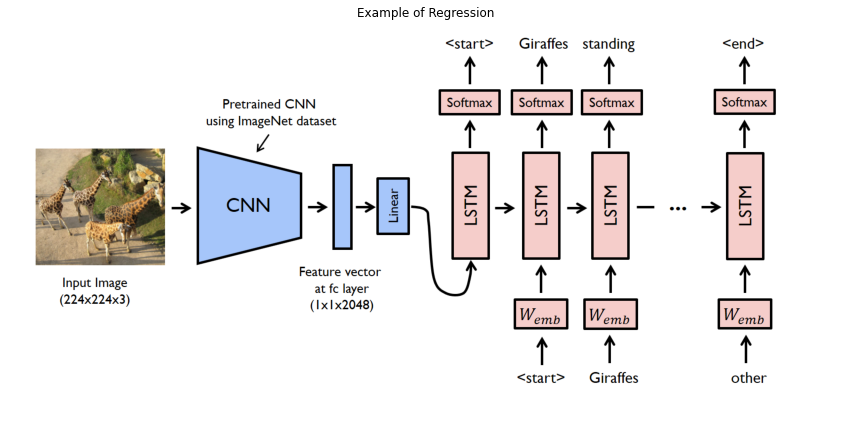

In [97]:
%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
img = mpimg.imread('g29.png')
plt.figure(figsize=(15,10))
plt.title("Example of Regression")
plt.axis("off")
imgplot = plt.imshow(img)

## Word Embedding

In [62]:
!wget http://nlp.stanford.edu/data/wordvecs/glove.6B.zip
!unzip glove.6B.zip

'wget' is not recognized as an internal or external command,
operable program or batch file.
'unzip' is not recognized as an internal or external command,
operable program or batch file.


In [63]:
f = open("D:\\Desktop\\datasets\\glove.6B.50d.txt", encoding = 'utf8')

In [64]:
embedding_index = {}

for line in f:
    values = line.split()
    word = values[0]
    coefs = np.asarray(values[1:], dtype="float")
    
    embedding_index[word] = coefs
    
f.close()

In [65]:
f.close()

In [66]:
embedding_index['apple']

array([ 0.52042 , -0.8314  ,  0.49961 ,  1.2893  ,  0.1151  ,  0.057521,
       -1.3753  , -0.97313 ,  0.18346 ,  0.47672 , -0.15112 ,  0.35532 ,
        0.25912 , -0.77857 ,  0.52181 ,  0.47695 , -1.4251  ,  0.858   ,
        0.59821 , -1.0903  ,  0.33574 , -0.60891 ,  0.41742 ,  0.21569 ,
       -0.07417 , -0.5822  , -0.4502  ,  0.17253 ,  0.16448 , -0.38413 ,
        2.3283  , -0.66682 , -0.58181 ,  0.74389 ,  0.095015, -0.47865 ,
       -0.84591 ,  0.38704 ,  0.23693 , -1.5523  ,  0.64802 , -0.16521 ,
       -1.4719  , -0.16224 ,  0.79857 ,  0.97391 ,  0.40027 , -0.21912 ,
       -0.30938 ,  0.26581 ])

## Converting words into vectors Directly - (Embedding Layer Output)


In [67]:
def get_embedding_output():
    
    emb_dim = 50
    embedding_output = np.zeros((vocab_size,emb_dim))
    
    for word, idx in word_to_idx.items():
        embedding_vector = embedding_index.get(word)
        
        if embedding_vector is not None:
            embedding_output[idx] = embedding_vector
            
    return embedding_output


embedding_output = get_embedding_output()

In [68]:
embedding_output.shape

(1848, 50)

In [69]:
#embedding_matrix[1847]

## Model Architecture

In [70]:
# image feature extractor model

input_img_fea = Input(shape=(2048,))
inp_img1 = Dropout(0.3)(input_img_fea)
inp_img2 = Dense(256, activation='relu')(inp_img1)

In [71]:
# partial caption sequence model

input_cap = Input(shape=(max_len,))
inp_cap1 = Embedding(input_dim=vocab_size, output_dim=50, mask_zero=True)(input_cap)
inp_cap2 = Dropout(0.3)(inp_cap1)
inp_cap3 = LSTM(256)(inp_cap2)

In [72]:
decoder1 = add([inp_img2 , inp_cap3])
decoder2 = Dense(256, activation='relu')(decoder1)
outputs = Dense(vocab_size, activation='softmax')(decoder2)

# Merge 2 networks
model = Model(inputs=[input_img_fea, input_cap], outputs=outputs)

In [73]:
model.summary() # Basicallly Show How my Lyers are connected

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            [(None, 35)]         0                                            
__________________________________________________________________________________________________
input_2 (InputLayer)            [(None, 2048)]       0                                            
__________________________________________________________________________________________________
embedding (Embedding)           (None, 35, 50)       92400       input_3[0][0]                    
__________________________________________________________________________________________________
dropout (Dropout)               (None, 2048)         0           input_2[0][0]                    
____________________________________________________________________________________________

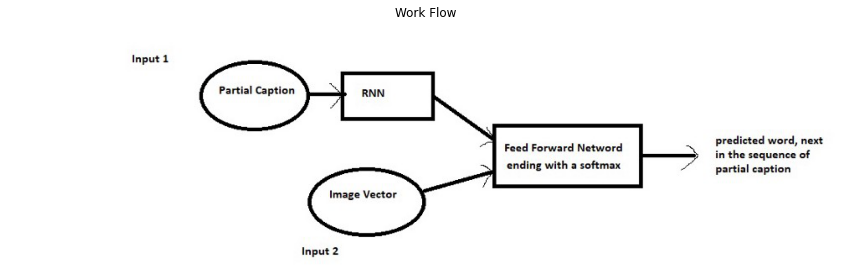

In [88]:
%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
img = mpimg.imread('g222.jpeg')
plt.figure(figsize=(15,15))
plt.title("Work Flow")
plt.axis("off")
imgplot = plt.imshow(img)

In [74]:
model.layers[2].set_weights([embedding_output])
model.layers[2].trainable = False

In [75]:
model.compile(loss="categorical_crossentropy", optimizer="adam")

### Training of Model

In [76]:
epochs = 15
number_pics_per_batch = 3
steps = len(train_descriptions)//number_pics_per_batch

In [77]:
for i in range(epochs):
    generator = data_generator(train_descriptions, encoding_train, word_to_idx, max_len, number_pics_per_batch)
    model.fit_generator(generator, epochs=1, steps_per_epoch=steps, verbose=1)
    model.save('./model_weights/model_' + str(i) + '.h5')

C:\Users\IRON MAN\anaconda3\lib\site-packages\tensorflow\python\keras\engine\training.py:1844: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


2000/2000 [==============================] - 763s 382ms/step - loss: 2.6551


## Predictions

In [78]:
def predict_caption(photo):
    in_text = "startseq"
    
    for i in range(max_len):
        sequence = [word_to_idx[w] for w in in_text.split() if w in word_to_idx]
        sequence = pad_sequences([sequence], maxlen=max_len, padding='post')

        ypred =  model.predict([photo,sequence])
        ypred = ypred.argmax()
        word = idx_to_word[ypred]
        in_text+= ' ' +word
        
        if word =='endseq':
            break
        
        
    final_caption =  in_text.split()
    final_caption = final_caption[1:-1]
    final_caption = ' '.join(final_caption)
    
    return final_caption

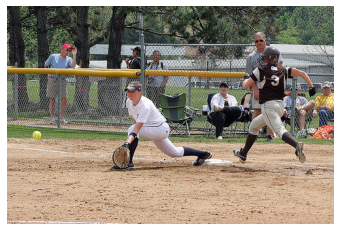

two children playing soccer on field


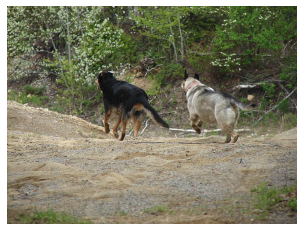

two dogs are walking through the woods


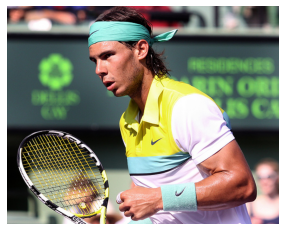

man in blue shirt and blue shirt is hitting tennis ball


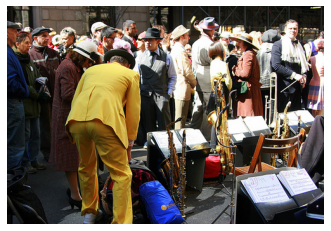

crowd of people are waiting in line in front of crowd of people


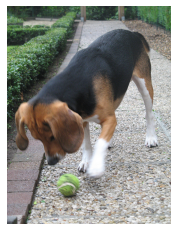

black and white dog is running on the grass


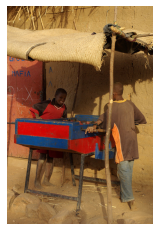

man in blue shirt is riding on horse


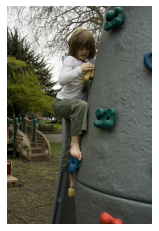

little boy in blue shirt is pushing on the little girl on the seat


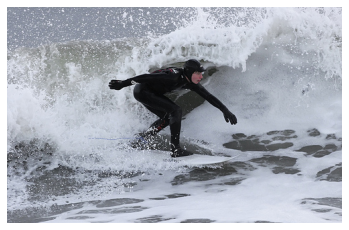

black dog is running through the snow


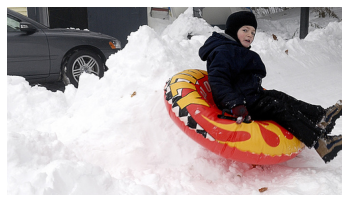

child in red jacket and red jacket is in the snow


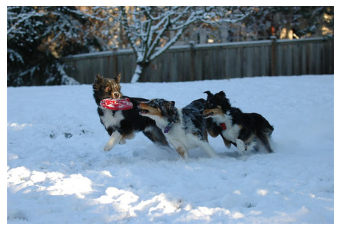

two dogs are running through snow


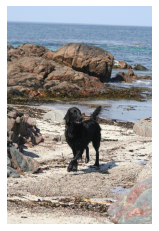

black dog is running on the beach


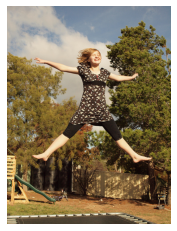

little girl in red shirt is running on the beach


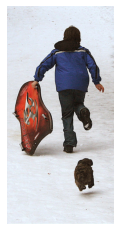

child in red jacket and red hat is pushing through the snow


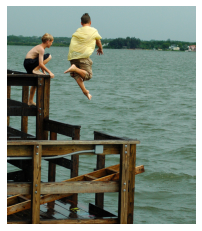

man in jeans is sitting on bench


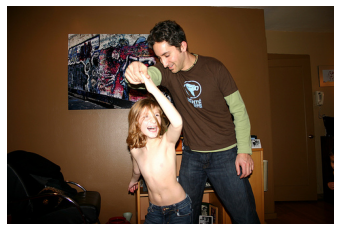

man in pajamas is sitting on the lap of his arm


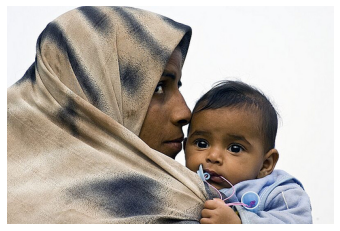

boy with his nose closed is holding camera


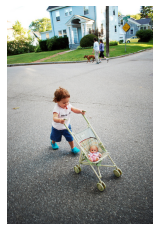

little girl in pink dress is swinging on swing


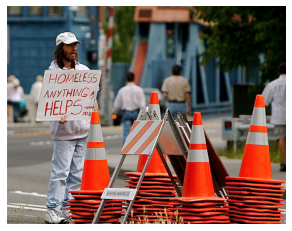

two girls in orange shirts are standing on the pavement


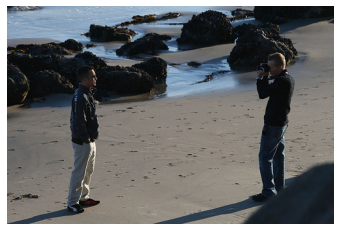

man in red shirt and black shorts is standing on beach


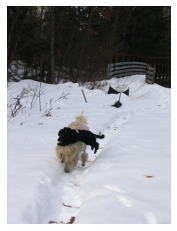

dog is running through the snow


In [80]:
for i in range(20):
    rn =  np.random.randint(0, 1000)

    img_name = list(encoding_test.keys())[rn]
    photo = encoding_test[img_name].reshape((1,2048))

    i = plt.imread(IMG_PATH +"/" +img_name+".jpg")
    plt.imshow(i)
    plt.axis("off")
    plt.show()

    caption = predict_caption(photo)
    print(caption)